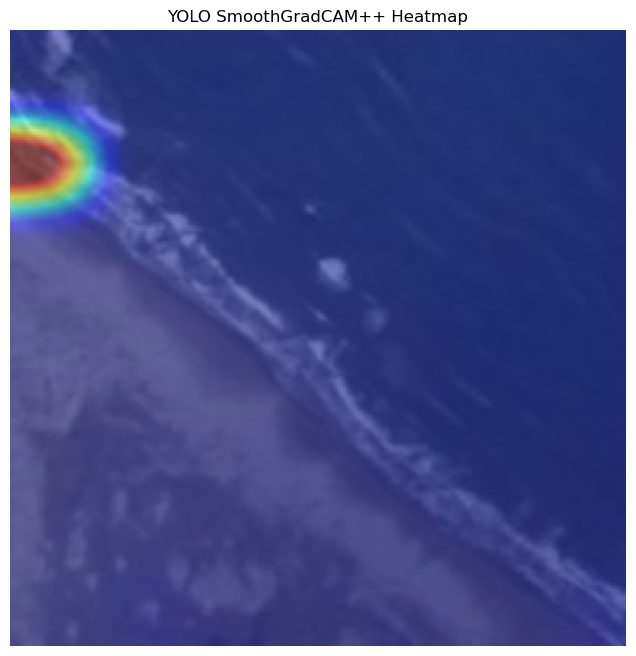

In [38]:
import torch
import torch.nn.functional as F
from ultralytics import YOLO
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask

# ---------------------------
# 1. 加载 YOLO 分类模型
# ---------------------------
# 请确保 yolo_12_best.pt 是经过分类任务微调后的权重
yolo_path = "/Users/yaogunzhishen/Desktop/yolo_12_best.pt"
model_wrapper = YOLO(yolo_path)
# 使用内部模型进行前向传播
model = model_wrapper.model
model.eval()  # 评估模式

# 选择设备（这里示例使用 MPS，如有 CUDA 可自行修改）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# ---------------------------
# 2. 图像预处理与类别映射
# ---------------------------
# 根据你训练时的预处理（此处示例使用与 ImageNet 相似的预处理）
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

])

# 加载并预处理单张图像
img_path = "/Users/yaogunzhishen/Desktop/datasets/test/Beach/009.jpg"  # 替换为你的图片路径
img = Image.open(img_path).convert("RGB")
input_tensor = preprocess(img).unsqueeze(0).to(device)

# 加载训练集映射（假设使用 ImageFolder 生成的映射）
train_dataset = datasets.ImageFolder(root='/Users/yaogunzhishen/Desktop/datasets/test', transform=preprocess)
class_to_idx = train_dataset.class_to_idx
# 反转字典，得到索引到类别名称的映射
idx_to_class = {v: k for k, v in class_to_idx.items()}

# ---------------------------
# 3. 生成 CAM 热力图（不输出预测信息）
# ---------------------------
# 手动指定目标层，例如选择模型内部倒数第二个卷积层（根据实际模型结构进行调整）
target_layer = model.model[-2]

# 为了计算梯度，将模型切换到 train 模式，并确保参数可求梯度
model.train()
for param in model.parameters():
    param.requires_grad = True

with SmoothGradCAMpp(model, target_layer=target_layer) as cam_extractor:
    out = model(input_tensor)
    # 如果返回的是 tuple，则提取第一个元素
    if isinstance(out, tuple):
        out = out[0]
    
    # 计算 softmax 概率并获取预测类别（仅用于生成热力图，不做输出）
    probs = F.softmax(out, dim=1)
    pred_class = out.squeeze(0).argmax().item()
    
    # 生成 CAM 热力图
    activation_map = cam_extractor(pred_class, out)[0]

# 生成 CAM 后将模型切换回评估模式
model.eval()

# ---------------------------
# 4. 可视化热力图
# ---------------------------
# 将输入图像和 activation map 转换为 PIL Image 格式
img_pil = to_pil_image(input_tensor.squeeze(0).cpu())
# activation_map 通常为单通道张量，使用 mode='F' 保持浮点格式
act_map_pil = to_pil_image(activation_map.squeeze(0), mode='F')
# 将热力图叠加在原图上
result = overlay_mask(img_pil, act_map_pil, alpha=0.5)

plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.axis('off')
plt.title("YOLO SmoothGradCAM++ Heatmap")
plt.show()

In [43]:
print(model.model[-2])

A2C2f(
  (cv1): Conv(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0-1): 2 x Sequential(
      (0): ABlock(
        (attn): AAttn(
          (qkv): Conv(
            (conv): Conv2d(128, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): Identity()
          )
          (proj): Conv(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act):